In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/avazu-ctr-prediction/sampleSubmission.gz
/kaggle/input/avazu-ctr-prediction/train.gz
/kaggle/input/avazu-ctr-prediction/test.gz


In [2]:
# Importing all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
sns.set()
plt.rcParams['image.cmap'] = 'viridis'

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', 0)
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import graphviz
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import random
import gzip
import category_encoders as ce
pd.options.display.float_format = '{:.2f}'.format

# Data Loading

In [4]:
# data paths
train_data_path = "/kaggle/input/avazu-ctr-prediction/train.gz"
test_data_path = "/kaggle/input/avazu-ctr-prediction/test.gz"

In [5]:
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

# get train data sample using pd chunks. Each chunk has a size of 1000000
train_data = pd.read_csv(train_data_path, chunksize = 1000000,parse_dates=['hour'], date_parser=parse_date)
train_df = pd.DataFrame()

for chunk in train_data:
    train_df = pd.concat([train_df, chunk.sample(frac=.1, replace=False, random_state=123)], axis=0)
train_df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
373315,2754752362988372992.00,1,2014-10-21 02:00:00,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,a8536f3a,711ee120,1,0,17753,320,50,1993,2,1063,-1,33
459286,9630799129494810624.00,0,2014-10-21 02:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,210b723a,711ee120,1,0,15699,320,50,1722,0,35,100083,79
262398,10482259799985475584.00,0,2014-10-21 02:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,225af2a8,b78e6543,1,0,15703,320,50,1722,0,35,100083,79
789396,18308563816330684416.00,0,2014-10-21 04:00:00,1005,1,b8eae5f9,1e334bd3,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,469c435d,8a4875bd,1,0,19950,320,50,1800,3,167,100077,23
383229,3559389347669503488.00,0,2014-10-21 02:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,d4e7897b,1f0bc64f,1,0,15701,320,50,1722,0,35,-1,79


In [6]:
# get the test data
test_data = pd.read_csv(test_data_path, chunksize = 1000000,parse_dates=['hour'], date_parser=parse_date)
test_df = pd.DataFrame()

for chunk in test_data:
    test_df = pd.concat([test_df, chunk], axis = 0)
test_df.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000174058809264128.00,2014-10-31,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,69f45779,0eb711ec,1,0,8330,320,50,761,3,175,100075,23
1,10000182526920855552.00,2014-10-31,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8d44657,ecb851b2,1,0,22676,320,50,2616,0,35,100083,51
2,10000554139829213184.00,2014-10-31,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,10fb085b,1f0bc64f,1,0,22676,320,50,2616,0,35,100083,51
3,10001094637809799168.00,2014-10-31,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,a99f214a,422d257a,542422a7,1,0,18648,320,50,1092,3,809,100156,61
4,10001377041558671360.00,2014-10-31,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,078c6b38,1f0bc64f,1,0,23160,320,50,2667,0,47,-1,221


# Data Exploration

In [7]:
test_df.shape

(4577464, 23)

In [8]:
train_df.shape

(4042897, 24)

In [9]:
test_df = test_df.loc[0:4042896]
test_df.shape

(4042897, 23)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4042897 entries, 373315 to 40337206
Data columns (total 24 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                float64       
 1   click             int64         
 2   hour              datetime64[ns]
 3   C1                int64         
 4   banner_pos        int64         
 5   site_id           object        
 6   site_domain       object        
 7   site_category     object        
 8   app_id            object        
 9   app_domain        object        
 10  app_category      object        
 11  device_id         object        
 12  device_ip         object        
 13  device_model      object        
 14  device_type       int64         
 15  device_conn_type  int64         
 16  C14               int64         
 17  C15               int64         
 18  C16               int64         
 19  C17               int64         
 20  C18               int64         
 21  C1

In [11]:
train_df.isna().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

In [12]:
train_df.nunique()

id                  4042897
click                     2
hour                    240
C1                        7
banner_pos                7
site_id                3426
site_domain            4270
site_category            23
app_id                 4899
app_domain              303
app_category             29
device_id            503388
device_ip           1634314
device_model           6386
device_type               5
device_conn_type          4
C14                    2434
C15                       8
C16                       9
C17                     425
C18                       4
C19                      66
C20                     168
C21                      60
dtype: int64

# Data Preprocessing

In [14]:
# hour column contains event date with all the details, extracting the same to create different columns.
train_df['month'] = train_df['hour'].dt.month
train_df['dayofweek'] = train_df['hour'].dt.dayofweek
train_df['day'] = train_df['hour'].dt.day
train_df['hour_time'] = train_df['hour'].dt.hour
train_df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
373315,2754752362988372992.00,1,2014-10-21 02:00:00,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,a8536f3a,711ee120,1,0,17753,320,50,1993,2,1063,-1,33,10,1,21,2
459286,9630799129494810624.00,0,2014-10-21 02:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,210b723a,711ee120,1,0,15699,320,50,1722,0,35,100083,79,10,1,21,2
262398,10482259799985475584.00,0,2014-10-21 02:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,225af2a8,b78e6543,1,0,15703,320,50,1722,0,35,100083,79,10,1,21,2
789396,18308563816330684416.00,0,2014-10-21 04:00:00,1005,1,b8eae5f9,1e334bd3,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,469c435d,8a4875bd,1,0,19950,320,50,1800,3,167,100077,23,10,1,21,4
383229,3559389347669503488.00,0,2014-10-21 02:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,d4e7897b,1f0bc64f,1,0,15701,320,50,1722,0,35,-1,79,10,1,21,2


In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4042897 entries, 373315 to 40337206
Data columns (total 28 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                float64       
 1   click             int64         
 2   hour              datetime64[ns]
 3   C1                int64         
 4   banner_pos        int64         
 5   site_id           object        
 6   site_domain       object        
 7   site_category     object        
 8   app_id            object        
 9   app_domain        object        
 10  app_category      object        
 11  device_id         object        
 12  device_ip         object        
 13  device_model      object        
 14  device_type       int64         
 15  device_conn_type  int64         
 16  C14               int64         
 17  C15               int64         
 18  C16               int64         
 19  C17               int64         
 20  C18               int64         
 21  C1

In [16]:
# Dealing with outliers by capping
col = ['C15', 'C16', 'C19', 'C21']
for col in col:
    percentiles = train_df[col].quantile(0.98)
    if train_df[col].quantile(0.98) < 0.5 * train_df[col].max():
        train_df[col][train_df[col] >= percentiles] = percentiles

In [18]:
# segrigating numerical and categorical variables.
numerical = []
categorical = []

for col in (train_df.columns):
    if train_df[col].dtype == "object":
        categorical.append(col)
    else:
        numerical.append(col)
print("numerical columns = ",numerical)
print("\ncategorical columns = ",categorical)

numerical columns =  ['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'month', 'dayofweek', 'day', 'hour_time']

categorical columns =  ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


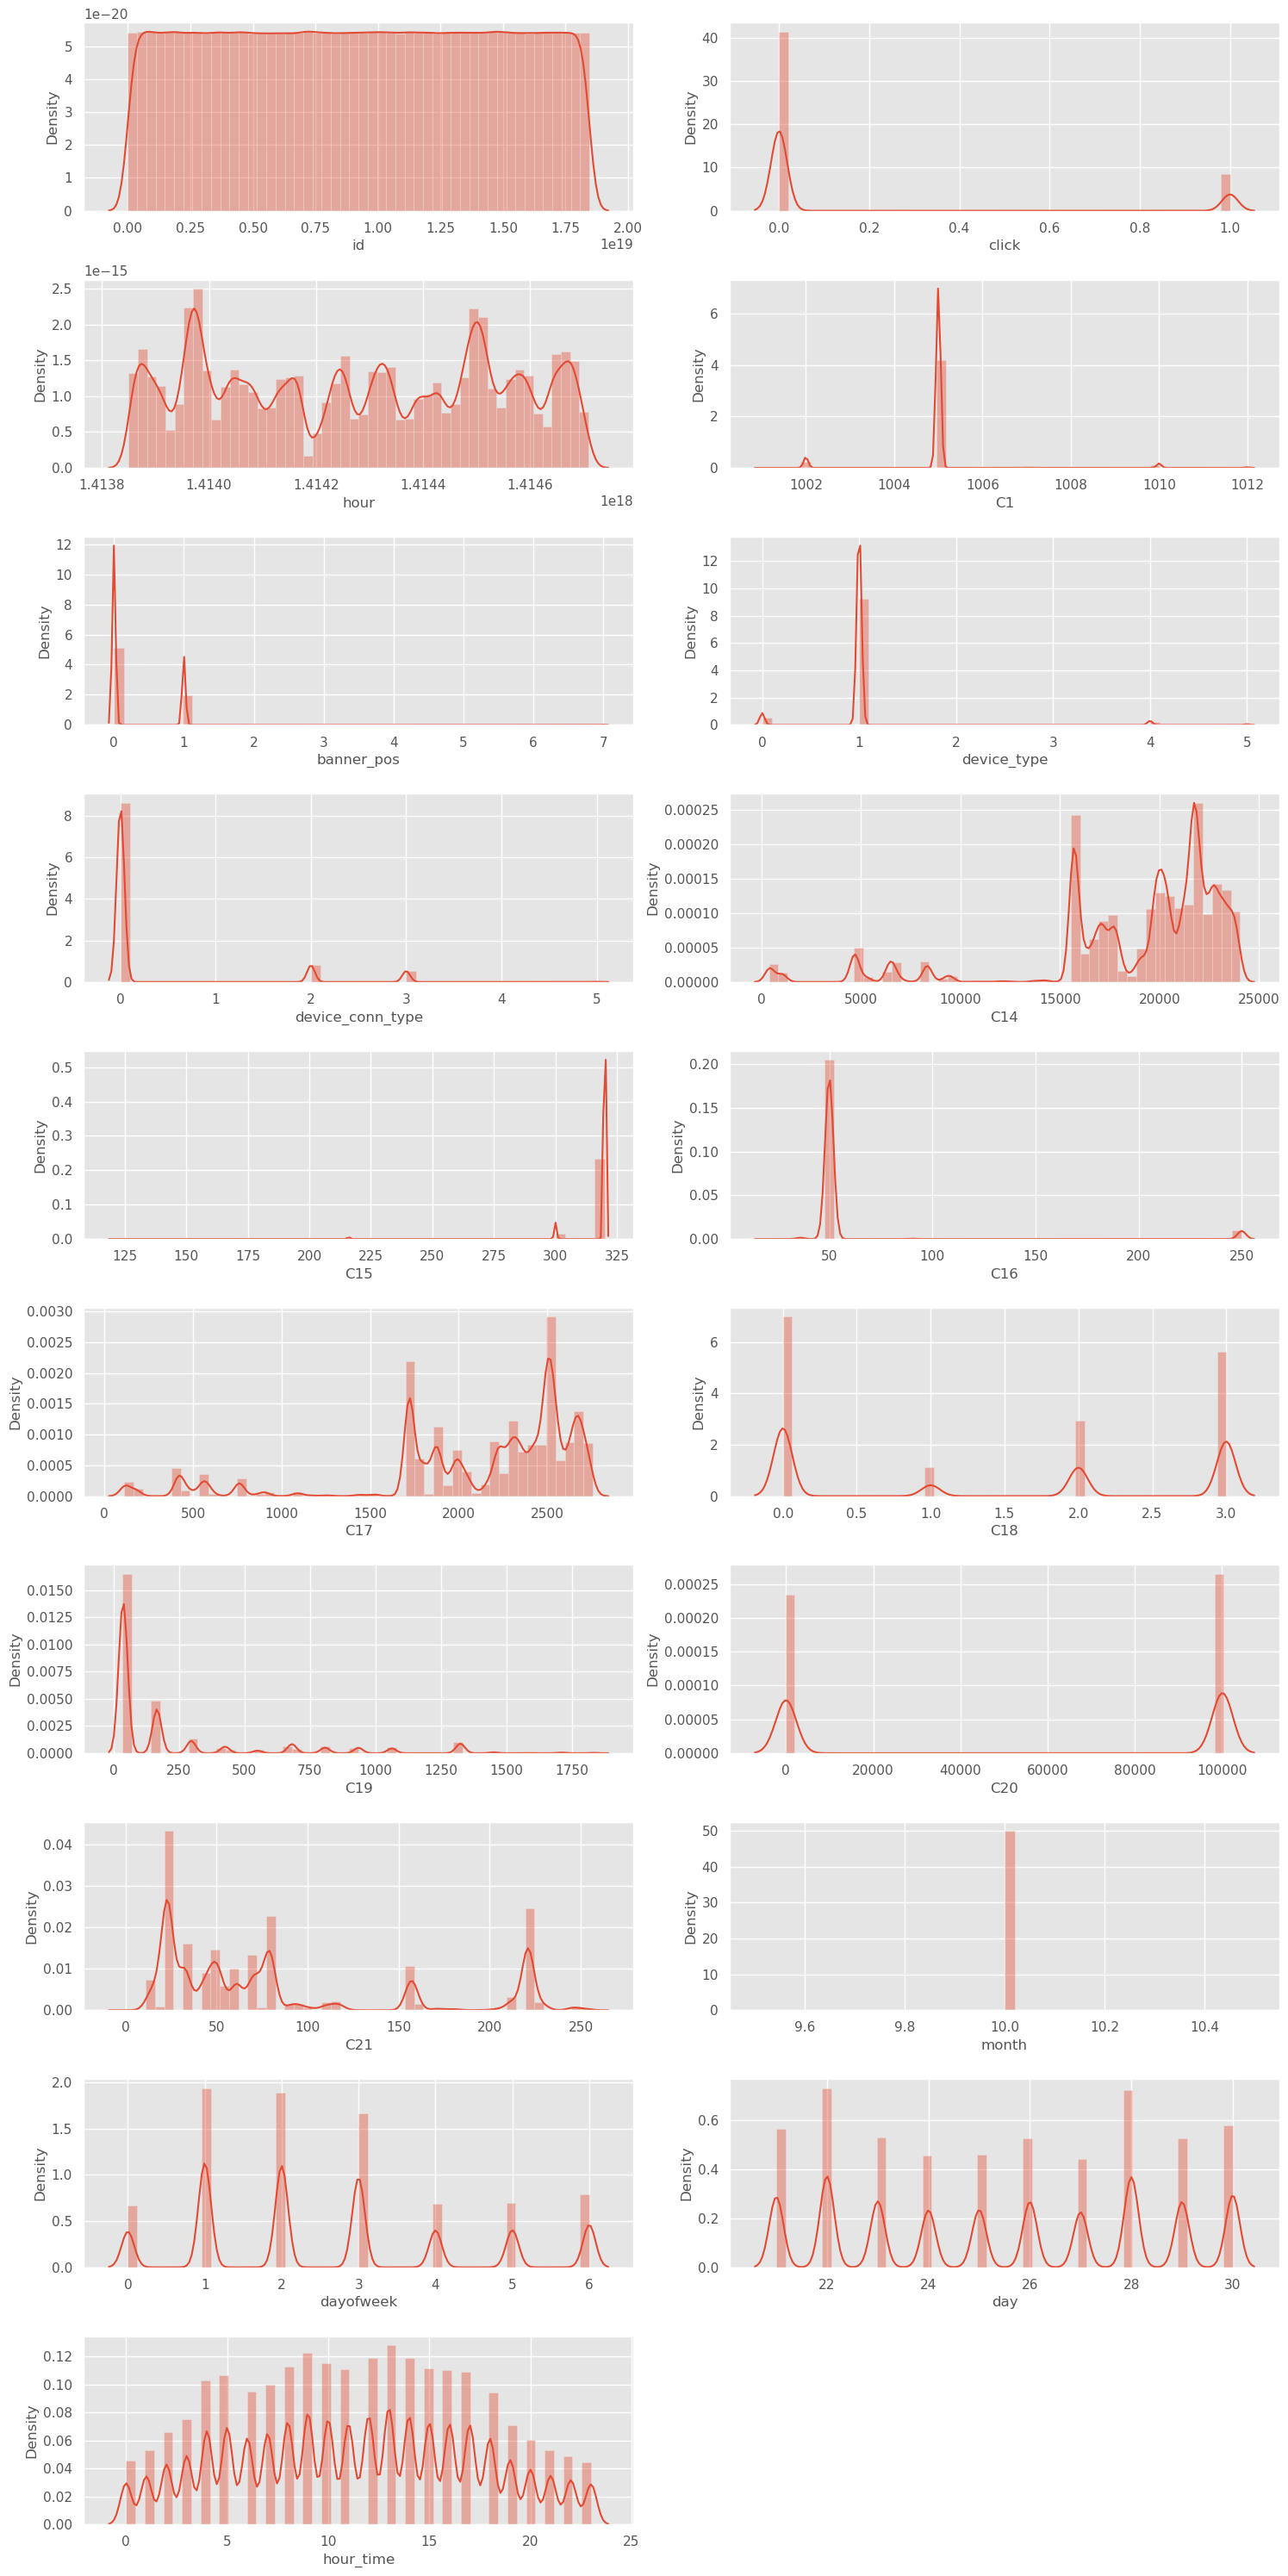

In [20]:
n = 2
plt.figure(figsize=[15,3*math.ceil(len(numerical)/n)])

for i in range(len(numerical)):
    plt.subplot(math.ceil(len(numerical)/n),n,i+1)
    sns.distplot(train_df[numerical[i]])

plt.tight_layout()
plt.show()

Text(0.5, 1.05, 'Pearson correlation of Features')

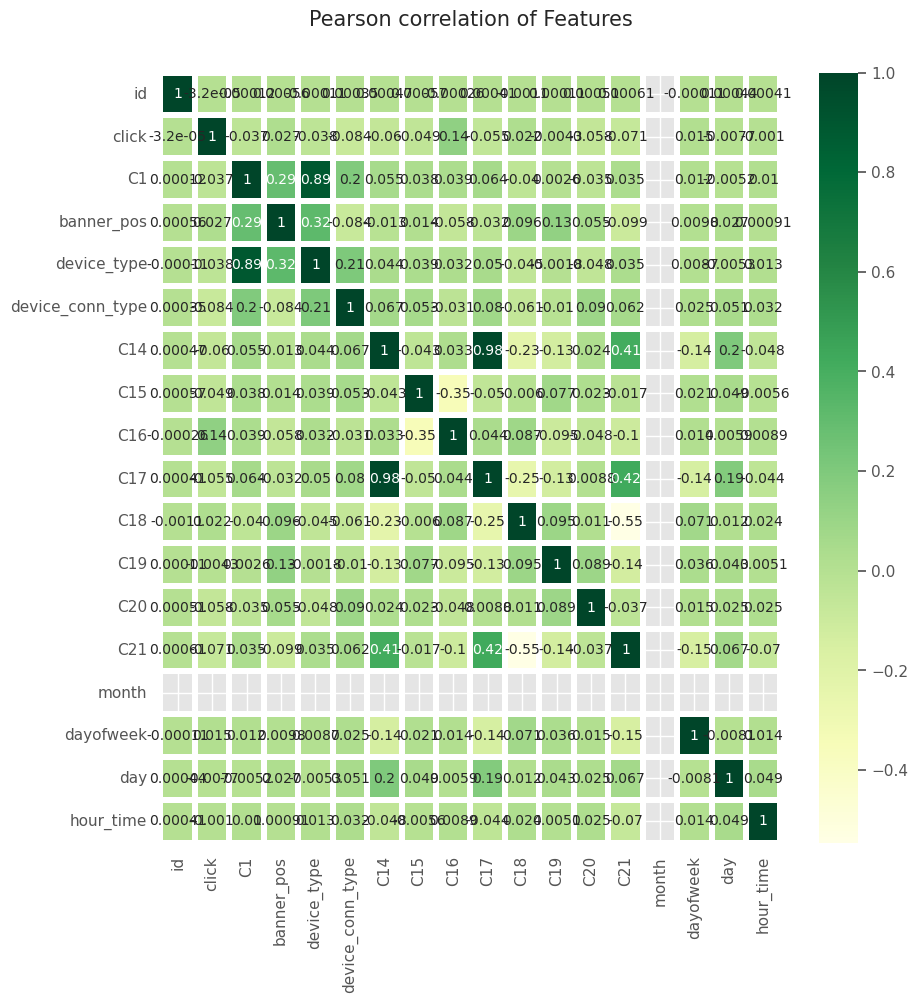

In [21]:
corr = train_df.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, ax=ax, annot=True,linewidths=3,cmap='YlGn')
plt.title("Pearson correlation of Features", y=1.05, size=15)

In [22]:
train_df.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'month', 'dayofweek',
       'day', 'hour_time'],
      dtype='object')

In [23]:
train_df.drop(['month', 'C20','id','hour'], axis=1, inplace=True)
train_df.columns

Index(['click', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
       'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C21', 'dayofweek', 'day', 'hour_time'],
      dtype='object')

In [24]:
train_df.rename(columns={'click': 'y',
                   'hour_time': 'hour'},
          inplace=True, errors='raise')

train_df.columns

Index(['y', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
       'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C21', 'dayofweek', 'day', 'hour'],
      dtype='object')

In [26]:
sampled_data = train_df.sample(frac=0.1, random_state=42)
X = sampled_data.drop(['y'], axis=1)
y = sampled_data['y']

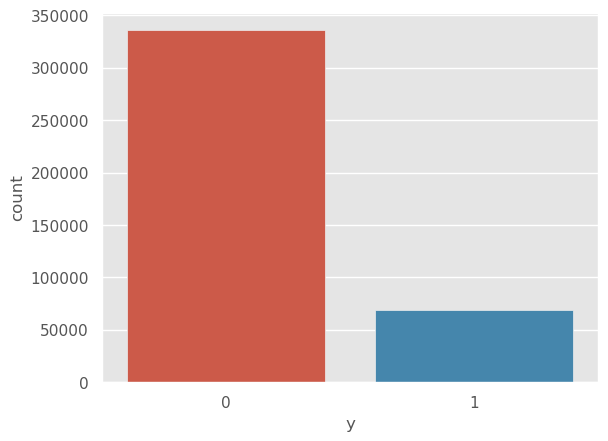

In [27]:
plt.figure()
sns.countplot(x=y)
plt.show()

In [28]:
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)
X.head()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
923485,1005,0,0.46,0.45,0.28,0.20,0.19,0.20,0.17,0.15,0.24,1,0,20019,300,250,2286,3,39,23,1,21,5
10580621,1005,1,0.30,0.26,0.18,0.20,0.19,0.20,0.17,0.15,0.23,1,0,20355,216,36,2333,0,39,157,3,23,6
11690453,1005,0,0.20,0.20,0.21,0.20,0.19,0.20,0.17,0.27,0.22,1,0,15707,320,50,1722,0,35,79,3,23,13
12631552,1005,0,0.20,0.20,0.21,0.20,0.19,0.20,0.17,0.13,0.26,1,0,15708,320,50,1722,0,35,79,3,23,18
26323775,1002,0,0.15,0.12,0.13,0.20,0.19,0.20,0.15,0.15,0.15,0,0,21789,320,50,2512,2,291,52,0,27,17


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size= 0.3, random_state= 42)

# Model Building

In [30]:
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
15049566,0.36,0.14,0.18,0.22,0.30,0.22,0.27,0.71,0.22,0.25,0.23,0.20,0.00,0.83,1.00,0.13,0.82,0.00,0.07,0.37,0.67,0.33,0.48
13146403,0.09,0.00,0.60,0.50,0.21,0.22,0.27,0.71,0.36,0.48,0.52,0.00,0.00,0.70,1.00,0.13,0.69,0.67,0.00,0.05,0.50,0.22,0.96
10393537,0.36,0.14,0.10,0.11,0.30,0.22,0.27,0.71,0.22,0.25,0.37,0.20,0.00,0.82,1.00,0.13,0.80,0.00,0.36,0.19,0.50,0.22,0.22
1761494,0.36,0.00,0.06,0.10,0.30,0.22,0.27,0.71,0.22,0.25,0.29,0.20,0.00,0.90,1.00,0.13,0.90,1.00,0.00,0.46,0.17,0.00,0.35
22611834,0.09,0.00,0.50,0.21,0.21,0.22,0.27,0.71,0.18,0.25,0.62,0.00,0.00,0.38,1.00,0.13,0.30,1.00,0.22,0.24,1.00,0.56,0.61


In [31]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [32]:
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_test.head()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
7889177,0.36,0.00,0.12,0.06,0.30,0.22,0.27,0.71,0.22,0.25,0.24,0.20,0.00,0.84,1.00,0.13,0.84,0.00,0.00,0.61,0.33,0.11,0.61
5937506,0.36,0.00,0.16,0.19,0.21,0.21,0.25,0.25,0.36,0.48,0.35,0.20,0.00,0.03,1.00,0.13,0.02,1.00,0.72,0.06,0.33,0.11,0.39
24809856,0.36,0.00,0.07,0.17,0.30,0.22,0.27,0.71,0.22,0.25,0.21,0.20,0.00,0.82,1.00,0.13,0.80,0.00,0.50,0.19,0.00,0.67,0.30
2904763,0.36,0.14,0.41,0.40,0.30,0.22,0.27,0.71,0.22,0.25,0.48,0.20,0.00,0.84,1.00,0.13,0.82,1.00,0.01,0.16,0.17,0.00,0.61
23216424,0.36,0.00,0.28,0.31,0.35,0.22,0.27,0.71,0.22,0.25,0.25,0.20,0.00,0.65,1.00,0.13,0.61,0.00,0.00,0.31,1.00,0.56,0.74


In [35]:
def model_eval(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    #print(accuracy)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, cnf_matrix

In [37]:
y_pred = model.predict(X_test)
accuracy, cnf_matrix = model_eval(model, X_test, y_test)
print(accuracy)
print(cnf_matrix)

0.9289206592627405
[[97812  2935]
 [ 5686 14854]]
